In [1]:
import json
import glob
import itertools

import numpy as np
import pandas as pd

from qiskit import transpile, QuantumCircuit
from qiskit.providers.fake_provider import FakeLima, ConfigurableFakeBackend
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers import Options
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import random_clifford
from qiskit.quantum_info import SparsePauliOp

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import (
    GCNConv, 
    TransformerConv, 
    GATv2Conv, 
    global_mean_pool, 
    Linear, 
    ChebConv, 
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from pprint import pprint

from qiskit.opflow import I, X, Z
from qiskit.primitives import Estimator
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.minimum_eigensolvers import VQE, VQEResult
from qiskit.algorithms.optimizers import SLSQP, SPSA, COBYLA

from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import AerSimulator

In [2]:
backend = ConfigurableFakeBackend("Tashkent", n_qubits=2, version=1,
                                 # qubit_t1=0.00011377694598809795,
                                 # qubit_t2=0.00010553074510239035
                                 ) #FakeLima()
properties = get_backend_properties_v1(backend)

ideal_estimator = AerEstimator(skip_transpilation=True) #Estimator()
aer_esimator = AerEstimator(skip_transpilation=True)
backend_estimator = BackendEstimator(backend, skip_transpilation=True)

In [3]:
# help(TwoLocal)

In [4]:
operator = (-1.052373245772859 * I ^ I) + \
            (0.39793742484318045 * I ^ Z) + \
            (-0.39793742484318045 * Z ^ I) + \
            (-0.01128010425623538 * Z ^ Z) + \
            (0.18093119978423156 * X ^ X)

ansatz = TwoLocal(rotation_blocks='rx', entanglement_blocks='cx', reps=3)
ansatz.num_qubits = operator.num_qubits

In [5]:
transpiled_ansatz = transpile(ansatz, backend, optimization_level=0)
transpiled_ansatz.draw(fold=-1)

┌───────────────────┐     ┌───────────────────┐     ┌───────────────────┐     ┌───────────────────┐
q_0 -> 0 ┤ U3(θ[0],-π/2,π/2) ├──■──┤ U3(θ[2],-π/2,π/2) ├──■──┤ U3(θ[4],-π/2,π/2) ├──■──┤ U3(θ[6],-π/2,π/2) ├
         ├───────────────────┤┌─┴─┐├───────────────────┤┌─┴─┐├───────────────────┤┌─┴─┐├───────────────────┤
q_1 -> 1 ┤ U3(θ[1],-π/2,π/2) ├┤ X ├┤ U3(θ[3],-π/2,π/2) ├┤ X ├┤ U3(θ[5],-π/2,π/2) ├┤ X ├┤ U3(θ[7],-π/2,π/2) ├
         └───────────────────┘└───┘└───────────────────┘└───┘└───────────────────┘└───┘└───────────────────┘

In [6]:
### Create training dataset

In [7]:
num_params = len(list(ansatz.parameters))

In [8]:
N_FILES = 20
N_ENTRIES_PER_FILE = 100

In [25]:


obs = encode_pauli_sum_op(operator)

for i in tqdm_notebook(range(N_FILES)):
    entries = []
    for _ in range(N_ENTRIES_PER_FILE):
        # transpiled_circuit = transpile(ansatz, backend, optimization_level=0)
        circuit = transpiled_ansatz.bind_parameters(np.random.uniform(-5, 5, (num_params)))

        exp_vals = create_meas_data_from_estimators(
            circuits=circuit, 
            observables=operator, 
            estimators=[ideal_estimator, backend_estimator],
            shots=10000
        )
        ideal_exp_val, noisy_exp_val = exp_vals

        graph_data = circuit_to_graph_data_json(
            circuit=circuit,
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )

        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=obs,
            ideal_exp_value=ideal_exp_val,
            noisy_exp_values=[
                noisy_exp_val
            ],
            circuit_depth=circuit.depth()
        )
        entries.append(entry.to_dict())

    with open(f"./data/demo_vqe_dataset/vqe_dataset_{i}.json", "w") as json_file:
        json.dump(entries, json_file)

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
### load data
import random

In [26]:
paths = glob.glob("./data/demo_vqe_dataset/vqe_dataset_**.json")
# random.shuffle(paths)
train_paths = paths[:13]
val_paths = paths[13:]

In [27]:
BATCH_SIZE = 32

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[352, 21], edge_index=[2, 736], edge_attr=[384, 3], y=[32, 1], observable=[32, 5, 9], circuit_depth=[32, 1], noisy_0=[32, 1], batch=[352], ptr=[33])


In [28]:
### Model

In [29]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()
        
        self.transformer1 = TransformerConv(
            num_node_features, hidden_channels,
            heads=3,
            dropout=0.1
        )
        self.pooling1 = ASAPooling(hidden_channels * 3, 0.5)

        self.transformer2 = TransformerConv(
            hidden_channels * 3, hidden_channels,
            heads=2,
            dropout=0.1
        )
        self.pooling2 = ASAPooling(hidden_channels * 2, 0.5)
        
        self.body_seq = torch.nn.Sequential(
            Linear(hidden_channels * 2 + 2, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 1)
        )

    def forward(self, 
                exp_value, observable, 
                circuit_depth, nodes, 
                edge_index, batch):
        graph = self.transformer1(nodes, edge_index)    
        graph, edge_index, _, batch, _ = self.pooling1(
            graph, edge_index, batch=batch
        )
        
        graph = self.transformer2(graph, edge_index)
        graph, edge_index, _, batch, _ = self.pooling2(
            graph, edge_index, batch=batch
        )
        
        graph = global_mean_pool(graph, batch)
    
        merge = torch.cat((
            graph, 
            exp_value,
            circuit_depth
        ), dim=1)

        return self.body_seq(merge)

In [30]:
model = ExpValCircuitGraphModel(
    num_node_features=21, 
    hidden_channels=10
)
criterion = torch.nn.MSELoss()

In [31]:
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 
                              'min', 
                              factor=0.1, 
                              patience=15, 
                              verbose=True, 
                              min_lr=0.00001)

In [32]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 100

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth,
            data.x, 
            data.edge_index, 
            data.batch
        )
        loss = criterion(out, data.y)        
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
                
    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth, 
            data.x, 
            data.edge_index, 
            data.batch)
        loss = criterion(out, data.y)        

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:    
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 00082: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00098: reducing learning rate of group 0 to 1.0000e-05.


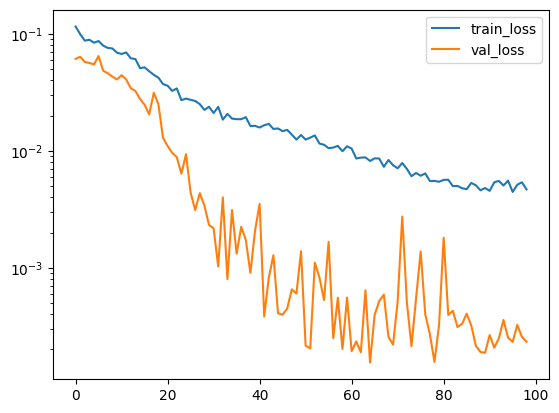

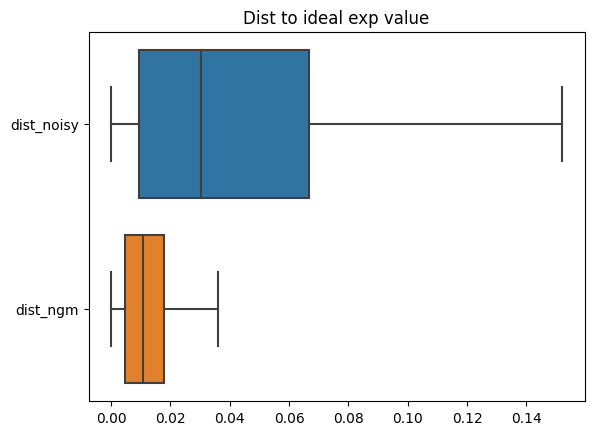

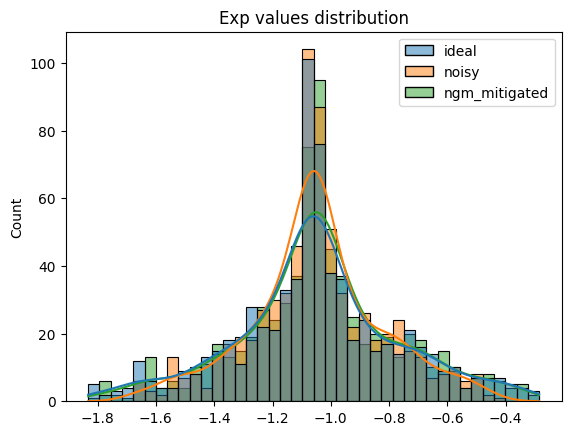

In [33]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

distances = []
for i, data in enumerate(val_loader):
    out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
    
    for ideal, noisy, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy_0.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
        })
        
df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [34]:
ideal_vals = []
ideal_callback = lambda count, params, mean, std: ideal_vals.append(mean)

noisy_vals = []
noisy_callback = lambda count, params, mean, std: noisy_vals.append(mean)

mitigated_vals = []
mitigated_callback = lambda count, params, mean, std: mitigated_vals.append(mean)

default_callback = lambda count, params, mean, std: print(mean, params)

initial_point = np.ones(num_params) #np.random.random(num_params)# 

options = Options(optimization_level=0)
NgemEstimator = ngem(BackendEstimator, model=model, backend=backend, options=options)
ngem_estimator = NgemEstimator(backend, skip_transpilation=True)

for estimator, callback in zip(
    [
        ideal_estimator, 
        ngem_estimator, 
        backend_estimator
    ],
    [
        ideal_callback, 
        mitigated_callback, 
        noisy_callback
    ]
):
    print(f"{estimator} VQE execution...")
    # vqe_optimizer = SPSA(maxiter=100) 
    vqe_optimizer = COBYLA(maxiter=500, tol=0.0001)
    vqe = VQE(estimator, transpiled_ansatz, vqe_optimizer, callback=callback, initial_point=initial_point)
    result = vqe.compute_minimum_eigenvalue(operator)

<qiskit_aer.primitives.estimator.Estimator object at 0x7fe8a80cb790> VQE execution...
<abc.NGEMBackendEstimator object at 0x7fe8c92daa90> VQE execution...
<qiskit.primitives.backend_estimator.BackendEstimator object at 0x7fe8df43e850> VQE execution...


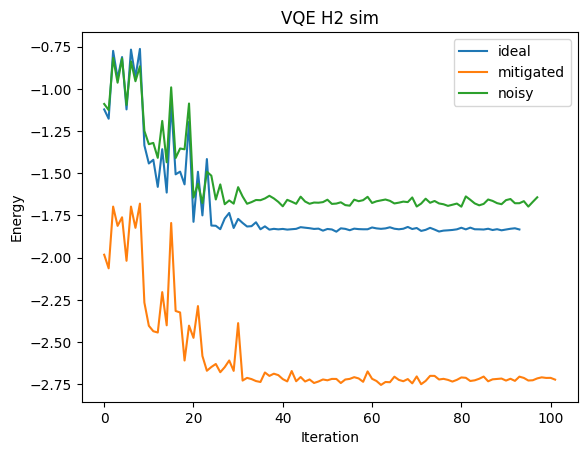

In [36]:
plt.plot(ideal_vals, label="ideal")
plt.plot(mitigated_vals, label="mitigated")
plt.plot(noisy_vals, label="noisy")
plt.legend()
# plt.yscale("log")
plt.title("VQE H2 sim")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

## H2

In [12]:
bond_operators = []

with open("./legacy/paper/data/molecule_data/h2-hamiltonian-qubit-params.txt", "r") as f:
    entries = f.read().split("\n\n")
    for entry in entries:
        length, fci, c1, c2, c3, c4, c5 = entry.split("\n")
        length = float(length.split(" ")[0])
        fci = float(fci.split(" ")[-1])
        
        c1, c2, c3, c4, c5 = [
            float(x.split(" ")[0]) for x in
            [c1, c2, c3, c4, c5]
        ]
                
        operator = (c1 * I ^ I) + \
                    (c2 * X ^ X) + \
                    (c3 * Z ^ I) + \
                    (c4 * Z ^ Z) + \
                    (c5 * I ^ Z)
        
        bond_operators.append((length, operator))
        
len(bond_operators)

16

In [13]:
ansatz = TwoLocal(rotation_blocks='rx', entanglement_blocks='cx', reps=3)
ansatz.num_qubits = operator.num_qubits

num_params = len(list(ansatz.parameters))

In [14]:
# for bond_length, operator in tqdm_notebook(bond_operators):
#     entries = []
#     obs = encode_pauli_sum_op(operator)
    
#     for _ in range(50):
#         circuit = transpiled_ansatz.bind_parameters(np.random.uniform(-5, 5, (num_params)))

#         exp_vals = create_meas_data_from_estimators(
#             circuits=circuit, 
#             observables=operator, 
#             estimators=[ideal_estimator, backend_estimator],
#             shots=10000
#         )
#         ideal_exp_val, noisy_exp_val = exp_vals

#         graph_data = circuit_to_graph_data_json(
#             circuit=circuit,
#             properties=properties,
#             use_qubit_features=True,
#             use_gate_features=True,
#         )

#         entry = ExpValueEntry(
#             circuit_graph=graph_data,
#             observable=obs,
#             ideal_exp_value=ideal_exp_val,
#             noisy_exp_values=[
#                 noisy_exp_val
#             ],
#             circuit_depth=circuit.depth()
#         )
#         entries.append(entry.to_dict())

#     with open(f"./data/vqe/h2/val/bond_{bond_length}.json", "w") as json_file:
#         json.dump(entries, json_file)

In [14]:
##  load data

In [15]:
train_paths = glob.glob("./legacy/paper/data/vqe/h2/train/**.json")
val_paths = glob.glob("./legacy/paper/data/vqe/h2/val/**.json")

In [16]:
BATCH_SIZE = 32

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[352, 21], edge_index=[2, 736], edge_attr=[384, 3], y=[32, 1], observable=[32, 5, 9], circuit_depth=[32, 1], noisy_0=[32, 1], batch=[352], ptr=[33])


In [34]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()
        
        self.transformer1 = TransformerConv(
            num_node_features, hidden_channels,
            heads=3,
            dropout=0.1
        )
        self.pooling1 = ASAPooling(hidden_channels * 3, 0.5)

        self.transformer2 = TransformerConv(
            hidden_channels * 3, hidden_channels,
            heads=2,
            dropout=0.1
        )
        self.pooling2 = ASAPooling(hidden_channels * 2, 0.5)
        
        self.body_seq = torch.nn.Sequential(
            Linear(hidden_channels * 2 + 7, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 1)
        )

    def forward(self, 
                exp_value, observable, 
                circuit_depth, nodes, 
                edge_index, batch):
        graph = self.transformer1(nodes, edge_index)    
        graph, edge_index, _, batch, _ = self.pooling1(
            graph, edge_index, batch=batch
        )
        
        graph = self.transformer2(graph, edge_index)
        graph, edge_index, _, batch, _ = self.pooling2(
            graph, edge_index, batch=batch
        )
        
        graph = global_mean_pool(graph, batch)
    
        obs_vec = observable[:, :, 0]

        merge = torch.cat((
            graph, 
            exp_value,
            circuit_depth,
            obs_vec
        ), dim=1)

        return self.body_seq(merge)

In [35]:
model = ExpValCircuitGraphModel(
    num_node_features=21, 
    hidden_channels=20
)
criterion = torch.nn.MSELoss()

In [36]:
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 
                              'min', 
                              factor=0.1, 
                              patience=15, 
                              verbose=True, 
                              min_lr=0.00001)

In [37]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 50

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth,
            data.x, 
            data.edge_index, 
            data.batch
        )
        loss = criterion(out, data.y)        
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
                
    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth, 
            data.x, 
            data.edge_index, 
            data.batch)
        loss = criterion(out, data.y)        

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:    
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/50 [00:00<?, ?it/s]

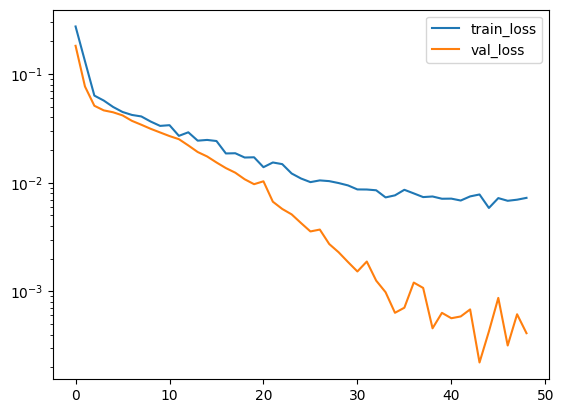

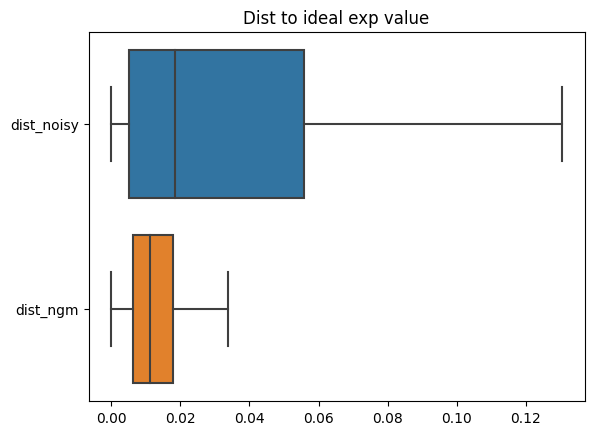

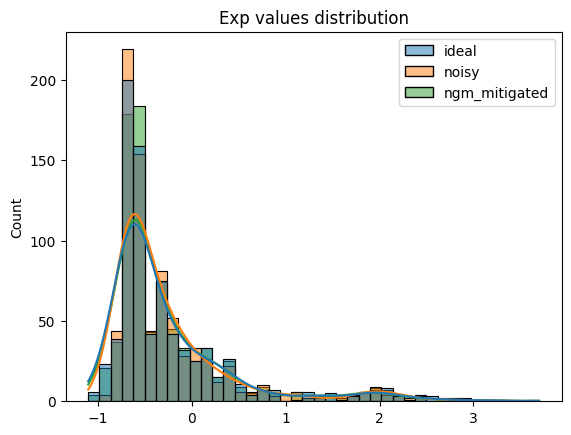

In [38]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

distances = []
for i, data in enumerate(val_loader):
    out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
    
    for ideal, noisy, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy_0.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
        })
        
df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [39]:
## test estimator

In [40]:
initial_point = np.ones(num_params) #np.random.random(num_params)# 

optimal_values = []

options = Options(optimization_level=0)
NgemEstimator = ngem(BackendEstimator, model=model, backend=backend, options=options)
ngem_estimator = NgemEstimator(backend, skip_transpilation=True)


#ideal_estimator,  ngem_estimator, backend_estimator
vqe_optimizer = COBYLA(maxiter=100, tol=0.0001)

In [41]:
ideal_values = []
ideal_histories = []
for bond_length, operator in tqdm_notebook(bond_operators):
    ideal_history = []
    ideal_callback = lambda a, b, c, d: ideal_history.append(c)
    vqe = VQE(ideal_estimator, transpiled_ansatz, vqe_optimizer, callback=ideal_callback, initial_point=initial_point)
    result = vqe.compute_minimum_eigenvalue(operator)
    ideal_values.append(result.optimal_value)
    ideal_histories.append(ideal_history)

  0%|          | 0/16 [00:00<?, ?it/s]

In [42]:
noisy_values = []
noisy_histories = []
for bond_length, operator in tqdm_notebook(bond_operators):
    noisy_history = []
    noisy_callback = lambda a, b, c, d: noisy_history.append(c)
    vqe = VQE(backend_estimator, transpiled_ansatz, vqe_optimizer, callback=noisy_callback, initial_point=initial_point)
    result = vqe.compute_minimum_eigenvalue(operator)
    noisy_values.append(result.optimal_value)
    noisy_histories.append(noisy_history)

  0%|          | 0/16 [00:00<?, ?it/s]

In [43]:
mitigated_values = []
mitigated_histories = []
for bond_length, operator in tqdm_notebook(bond_operators):
    mitigated_history = []
    mitigated_callback = lambda a, b, c, d: mitigated_history.append(c)
    vqe = VQE(ngem_estimator, transpiled_ansatz, vqe_optimizer, callback=mitigated_callback, initial_point=initial_point)
    result = vqe.compute_minimum_eigenvalue(operator)
    mitigated_values.append(result.optimal_value)
    mitigated_histories.append(mitigated_history)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
blenghts = [l for l, _ in bond_operators]

plt.plot(blenghts, ideal_values, label="ideal")
plt.plot(blenghts, noisy_values, 'ro--', linewidth=1, markersize=4, label="noisy")
plt.plot(blenghts, mitigated_values, 'go--', linewidth=1, markersize=4, label="mitigated")

plt.title("VQE on H2 molecule (sim)")
plt.xlabel("Bond length")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [152]:
with open("./data/results/vqe_h2.json", "w") as f:
    json.dump({
        "bond_lengths": blenghts,
        "ideal_values": ideal_values,
        "noisy_values": noisy_values,
        "mitigated_values": mitigated_values
    }, f)

## H2 with random clifford ansatz

In [46]:
bond_operators = []

with open("./legacy/paper/data/molecule_data/h2-hamiltonian-qubit-params.txt", "r") as f:
    entries = f.read().split("\n\n")
    for entry in entries:
        length, fci, c1, c2, c3, c4, c5 = entry.split("\n")
        length = float(length.split(" ")[0])
        fci = float(fci.split(" ")[-1])
        
        c1, c2, c3, c4, c5 = [
            float(x.split(" ")[0]) for x in
            [c1, c2, c3, c4, c5]
        ]
                
        operator = (c1 * I ^ I) + \
                    (c2 * X ^ X) + \
                    (c3 * Z ^ I) + \
                    (c4 * Z ^ Z) + \
                    (c5 * I ^ Z)
        
        bond_operators.append((length, operator))
        
len(bond_operators)

16

In [47]:
num_qubits = 2

In [48]:
backend = ConfigurableFakeBackend("Tashkent_4q", n_qubits=num_qubits, version=1)
properties = get_backend_properties_v1(backend)

ideal_estimator = AerEstimator(skip_transpilation=True)
aer_esimator = AerEstimator(skip_transpilation=True)
backend_estimator = BackendEstimator(backend, skip_transpilation=True)

In [49]:
tc = transpile(random_clifford(num_qubits).to_circuit(), backend, optimization_level=3, seed_transpiler=42)
tc.draw(fold=-1)

ideal_estimator.run([tc], [SparsePauliOp("ZZ")]).result()

EstimatorResult(values=array([0.01171875]), metadata=[{'shots': 1024, 'variance': 0.9998626708984375, 'simulator_metadata': [{'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000334584, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'device': 'CPU', 'active_input_qubits': [0, 1], 'measure_sampling': True, 'num_clbits': 2, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'statevector', 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 14, 'enabled': True}}]}])

In [50]:
ansatz = TwoLocal(rotation_blocks='rx', entanglement_blocks='cx', reps=2)
ansatz.num_qubits = num_qubits

num_params = len(list(ansatz.parameters))

transpiled_ansatz = transpile(ansatz, backend, optimization_level=0, seed_transpiler=42)
transpiled_ansatz.draw(fold=-1)

┌───────────────────┐     ┌───────────────────┐     ┌───────────────────┐
q_0 -> 0 ┤ U3(θ[0],-π/2,π/2) ├──■──┤ U3(θ[2],-π/2,π/2) ├──■──┤ U3(θ[4],-π/2,π/2) ├
         ├───────────────────┤┌─┴─┐├───────────────────┤┌─┴─┐├───────────────────┤
q_1 -> 1 ┤ U3(θ[1],-π/2,π/2) ├┤ X ├┤ U3(θ[3],-π/2,π/2) ├┤ X ├┤ U3(θ[5],-π/2,π/2) ├
         └───────────────────┘└───┘└───────────────────┘└───┘└───────────────────┘

In [51]:
# for bond_length, operator in tqdm_notebook(bond_operators):
#     entries = []
#     obs = encode_pauli_sum_op(operator)
    
#     for _ in tqdm_notebook(range(50)):
#         circuit = transpile(random_clifford(num_qubits).to_circuit(), 
#                   backend, 
#                   optimization_level=3, 
#                   seed_transpiler=42
#                  )

#         exp_vals = create_meas_data_from_estimators(
#             circuits=circuit, 
#             observables=operator, 
#             estimators=[ideal_estimator, backend_estimator],
#             shots=10000
#         )
#         ideal_exp_val, noisy_exp_val = exp_vals

#         graph_data = circuit_to_graph_data_json(
#             circuit=circuit,
#             properties=properties,
#             use_qubit_features=True,
#             use_gate_features=True,
#         )

#         entry = ExpValueEntry(
#             circuit_graph=graph_data,
#             observable=obs,
#             ideal_exp_value=ideal_exp_val,
#             noisy_exp_values=[
#                 noisy_exp_val
#             ],
#             circuit_depth=circuit.depth()
#         )
#         entries.append(entry.to_dict())

#     with open(f"./data/vqe/h2_clifford/val/bond_{bond_length}.json", "w") as json_file:
#         json.dump(entries, json_file)

In [54]:
train_paths = glob.glob("./legacy/paper/data/vqe/h2_clifford/train/**.json")
val_paths = glob.glob("./legacy/paper/data/vqe/h2_clifford/val/**.json")

In [55]:
BATCH_SIZE = 32

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[188, 21], edge_index=[2, 356], edge_attr=[168, 3], y=[32, 1], observable=[32, 5, 9], circuit_depth=[32, 1], noisy_0=[32, 1], batch=[188], ptr=[33])


In [56]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()
        
        self.transformer1 = TransformerConv(
            num_node_features, hidden_channels,
            heads=3,
            dropout=0.1
        )
        self.pooling1 = ASAPooling(hidden_channels * 3, 0.5)

        self.transformer2 = TransformerConv(
            hidden_channels * 3, hidden_channels,
            heads=2,
            dropout=0.1
        )
        self.pooling2 = ASAPooling(hidden_channels * 2, 0.5)
        
        self.body_seq = torch.nn.Sequential(
            Linear(hidden_channels * 2 + 7, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 1)
        )

    def forward(self, 
                exp_value, observable, 
                circuit_depth, nodes, 
                edge_index, batch):
        graph = self.transformer1(nodes, edge_index)    
        graph, edge_index, _, batch, _ = self.pooling1(
            graph, edge_index, batch=batch
        )
        
        graph = self.transformer2(graph, edge_index)
        graph, edge_index, _, batch, _ = self.pooling2(
            graph, edge_index, batch=batch
        )
        
        graph = global_mean_pool(graph, batch)
    
        obs_vec = observable[:, :, 0]

        merge = torch.cat((
            graph, 
            exp_value,
            circuit_depth,
            obs_vec
        ), dim=1)

        return self.body_seq(merge)

In [57]:
model = ExpValCircuitGraphModel(
    num_node_features=21, 
    hidden_channels=20
)
criterion = torch.nn.MSELoss()

In [58]:
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 
                              'min', 
                              factor=0.1, 
                              patience=15, 
                              verbose=True, 
                              min_lr=0.00001)

In [59]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 100

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth,
            data.x, 
            data.edge_index, 
            data.batch
        )
        loss = criterion(out, data.y)        
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
                
    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth, 
            data.x, 
            data.edge_index, 
            data.batch)
        loss = criterion(out, data.y)        

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:    
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 00068: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00097: reducing learning rate of group 0 to 1.0000e-05.


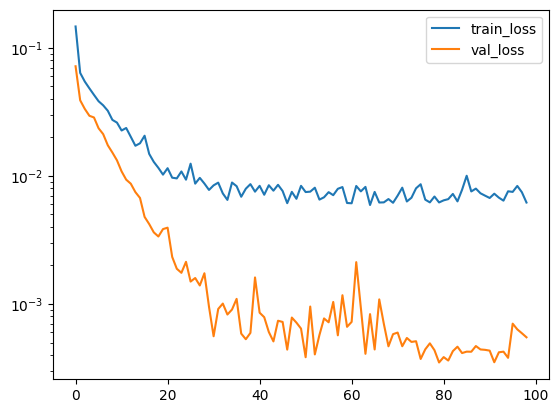

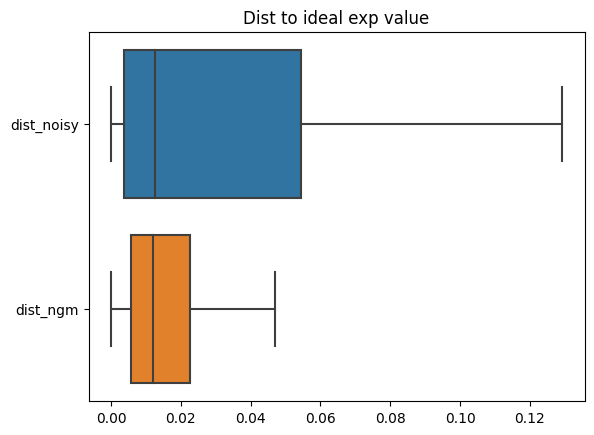

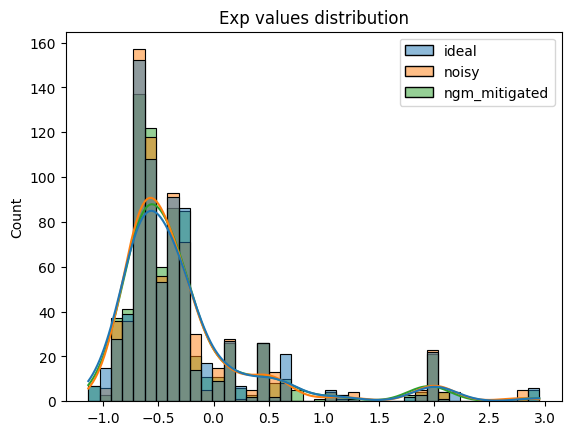

In [60]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

distances = []
for i, data in enumerate(val_loader):
    out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
    
    for ideal, noisy, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy_0.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
        })
        
df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [61]:
initial_point = np.ones(num_params) #np.random.random(num_params)# 

optimal_values = []

options = Options(optimization_level=0)
NgemEstimator = ngem(BackendEstimator, model=model, backend=backend, options=options)
ngem_estimator = NgemEstimator(backend, skip_transpilation=True)


#ideal_estimator,  ngem_estimator, backend_estimator
vqe_optimizer = COBYLA(maxiter=100, tol=0.0001)

In [62]:
ideal_values = []
ideal_histories = []
for bond_length, operator in tqdm_notebook(bond_operators):
    ideal_history = []
    ideal_callback = lambda a, b, c, d: ideal_history.append(c)
    vqe = VQE(ideal_estimator, transpiled_ansatz, vqe_optimizer, callback=ideal_callback, initial_point=initial_point)
    result = vqe.compute_minimum_eigenvalue(operator)
    ideal_values.append(result.optimal_value)
    ideal_histories.append(ideal_history)

  0%|          | 0/16 [00:00<?, ?it/s]

In [63]:
noisy_values = []
noisy_histories = []
for bond_length, operator in tqdm_notebook(bond_operators):
    noisy_history = []
    noisy_callback = lambda a, b, c, d: noisy_history.append(c)
    vqe = VQE(backend_estimator, transpiled_ansatz, vqe_optimizer, callback=noisy_callback, initial_point=initial_point)
    result = vqe.compute_minimum_eigenvalue(operator)
    noisy_values.append(result.optimal_value)
    noisy_histories.append(noisy_history)

  0%|          | 0/16 [00:00<?, ?it/s]

In [64]:
mitigated_values = []
mitigated_histories = []
for bond_length, operator in tqdm_notebook(bond_operators):
    mitigated_history = []
    mitigated_callback = lambda a, b, c, d: mitigated_history.append(c)
    vqe = VQE(ngem_estimator, transpiled_ansatz, vqe_optimizer, callback=mitigated_callback, initial_point=initial_point)
    result = vqe.compute_minimum_eigenvalue(operator)
    mitigated_values.append(result.optimal_value)
    mitigated_histories.append(mitigated_history)

  0%|          | 0/16 [00:00<?, ?it/s]

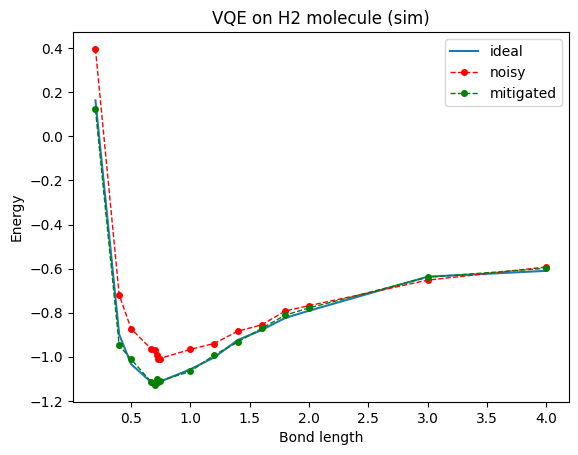

In [65]:
blenghts = [l for l, _ in bond_operators]

plt.plot(blenghts, ideal_values, label="ideal")
plt.plot(blenghts, noisy_values, 'ro--', linewidth=1, markersize=4, label="noisy")
plt.plot(blenghts, mitigated_values, 'go--', linewidth=1, markersize=4, label="mitigated")

plt.title("VQE on H2 molecule (sim)")
plt.xlabel("Bond length")
plt.ylabel("Energy")
plt.legend()
plt.show()

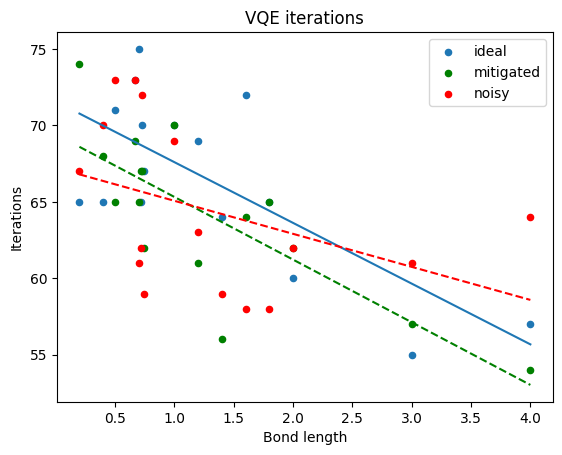

In [132]:
x = [l for l, _ in bond_operators]

ideal_interations = [len(h) for h in ideal_histories]
mitigated_iterations = [len(h) for h in mitigated_histories]
noisy_iterations = [len(h) for h in noisy_histories]

plt.scatter(x, ideal_interations, label="ideal", s=20)
plt.scatter(x, mitigated_iterations, c="g", label="mitigated", s=20)
plt.scatter(x, noisy_iterations, c="r", label="noisy", s=20)

ideal_p = np.poly1d(np.polyfit(x, ideal_interations, 1))
mitigated_p = np.poly1d(np.polyfit(x, mitigated_iterations, 1))
noisy_p = np.poly1d(np.polyfit(x, noisy_iterations, 1))

plt.plot(x, ideal_p(x))
plt.plot(x, mitigated_p(x), "g--")
plt.plot(x, noisy_p(x), "r--")

plt.legend()
plt.title("VQE iterations")
plt.xlabel("Bond length")
plt.ylabel("Iterations")
plt.show()

In [90]:
import math

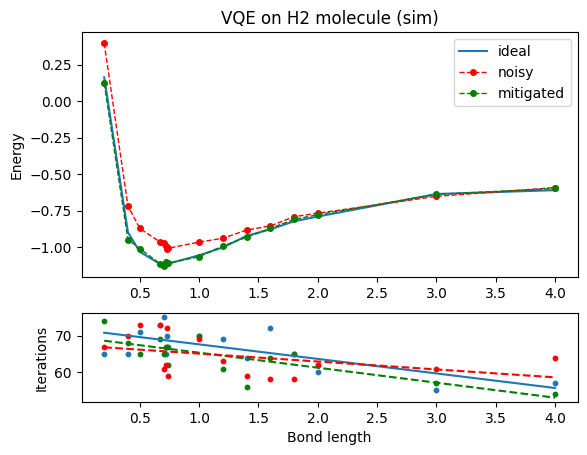

<Figure size 640x480 with 0 Axes>

In [142]:
# Placing the plots in the plane
plot1 = plt.subplot2grid((12, 2), (0, 0), colspan=2, rowspan=8)
plot2 = plt.subplot2grid((12, 2), (9, 0), colspan=2, rowspan=3)
  

blenghts = [l for l, _ in bond_operators]

plot1.plot(blenghts, ideal_values, label="ideal")
plot1.plot(blenghts, noisy_values, 'ro--', linewidth=1, markersize=4, label="noisy")
plot1.plot(blenghts, mitigated_values, 'go--', linewidth=1, markersize=4, label="mitigated")

plot1.set_title("VQE on H2 molecule (sim)")
# plot1.set_xlabel("Bond length")
plot1.set_ylabel("Energy")
plot1.legend()


x = [l for l, _ in bond_operators]

ideal_interations = [len(h) for h in ideal_histories]
mitigated_iterations = [len(h) for h in mitigated_histories]
noisy_iterations = [len(h) for h in noisy_histories]

plot2.scatter(x, ideal_interations, label="ideal", s=10)
plot2.scatter(x, mitigated_iterations, c="g", label="mitigated", s=10)
plot2.scatter(x, noisy_iterations, c="r", label="noisy", s=10)

ideal_p = np.poly1d(np.polyfit(x, ideal_interations, 1))
mitigated_p = np.poly1d(np.polyfit(x, mitigated_iterations, 1))
noisy_p = np.poly1d(np.polyfit(x, noisy_iterations, 1))

plot2.plot(x, ideal_p(x))
plot2.plot(x, mitigated_p(x), "g--")
plot2.plot(x, noisy_p(x), "r--")

# plot2.legend()
# plot2.set_title("VQE iterations")
plot2.set_xlabel("Bond length")
plot2.set_ylabel("Iterations")
plt.show()


plt.tight_layout()
plt.show()

In [143]:
with open("./results/vqe_h2_with_histories.json", "w") as f:
    json.dump({
        "bond_lengths": blenghts,
        "ideal_values": ideal_values,
        "noisy_values": noisy_values,
        "mitigated_values": mitigated_values,
        "ideal_histories": ideal_histories,
        "noisy_histories": noisy_histories,
        "mitigated_histories": mitigated_histories,
    }, f)